[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Aug  8 06:12:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.4/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/__init__.py", line 11, in <module>
    from ultralytics.models import NAS, RTDETR, SAM, YOLO, FastSAM, YOLOWorld
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/__init__.py", line 3, in <module>
    from .fastsam import FastSAM
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/fastsam/__init__.py", line 3, in <module>
    from .model import FastSAM
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/fastsam/model.py", line 5, in <module>
    from ultralytics.engine.model import Model
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 8, in <module>
    import torch
  File "/usr/local/lib/python3.11/dist-packages/torch/__init__.py", line 2604, in <module>
    from torch import _meta_registrations
  File "/usr/local/lib/p

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpeg', width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/predict/dog.jpeg'

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

In [ ]:
result.boxes.conf

In [ ]:
result.boxes.cls

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("yolorzk")
project = workspace.project("bird-fix-wegxy")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bird-fix-1 in yolov11:: 100%|██████████| 16439/16439 [00:06<00:00, 2513.74it/s]


## Custom Training

In [ ]:
%cd {HOME}/

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=75 imgsz=640 plots=True

/content
100% 5.35M/5.35M [00:00<00:00, 150MB/s]
New https://pypi.org/project/ultralytics/8.3.176 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/bird-fix-1/data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch26845.jpg
confusion_matrix.png				    train_batch26846.jpg
events.out.tfevents.1754633713.3627a454f545.4232.0  train_batch26847.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


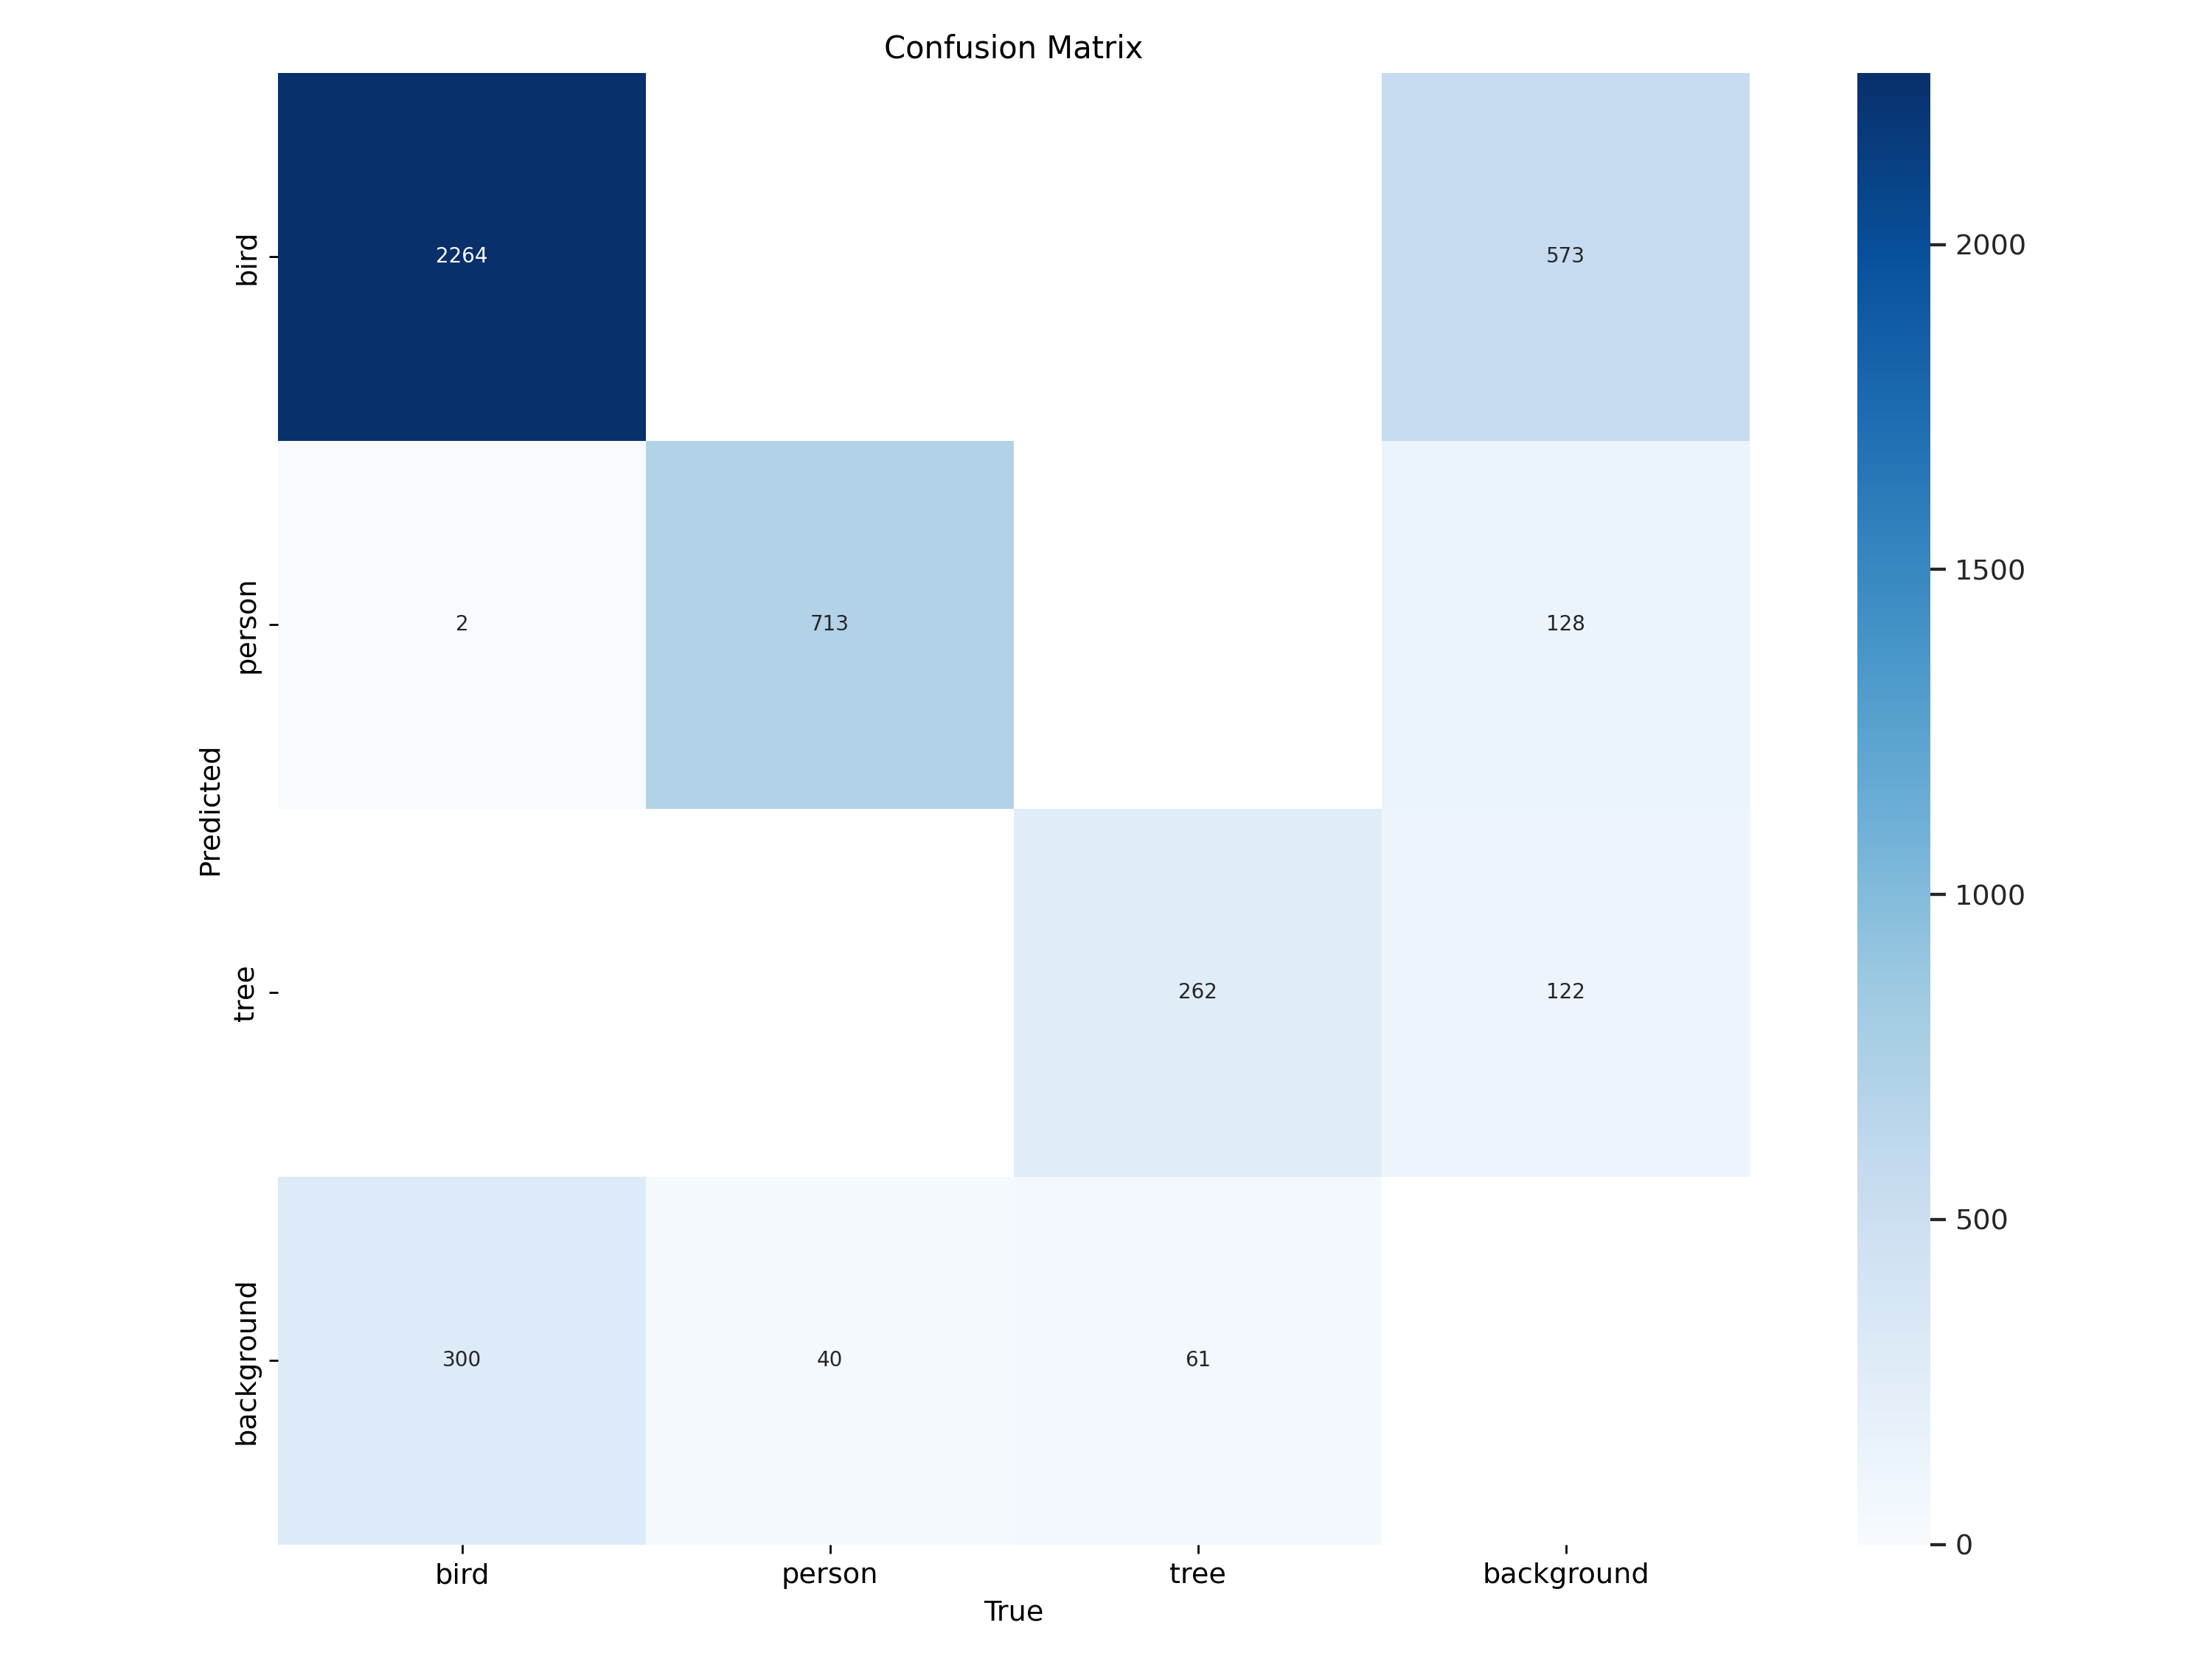

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

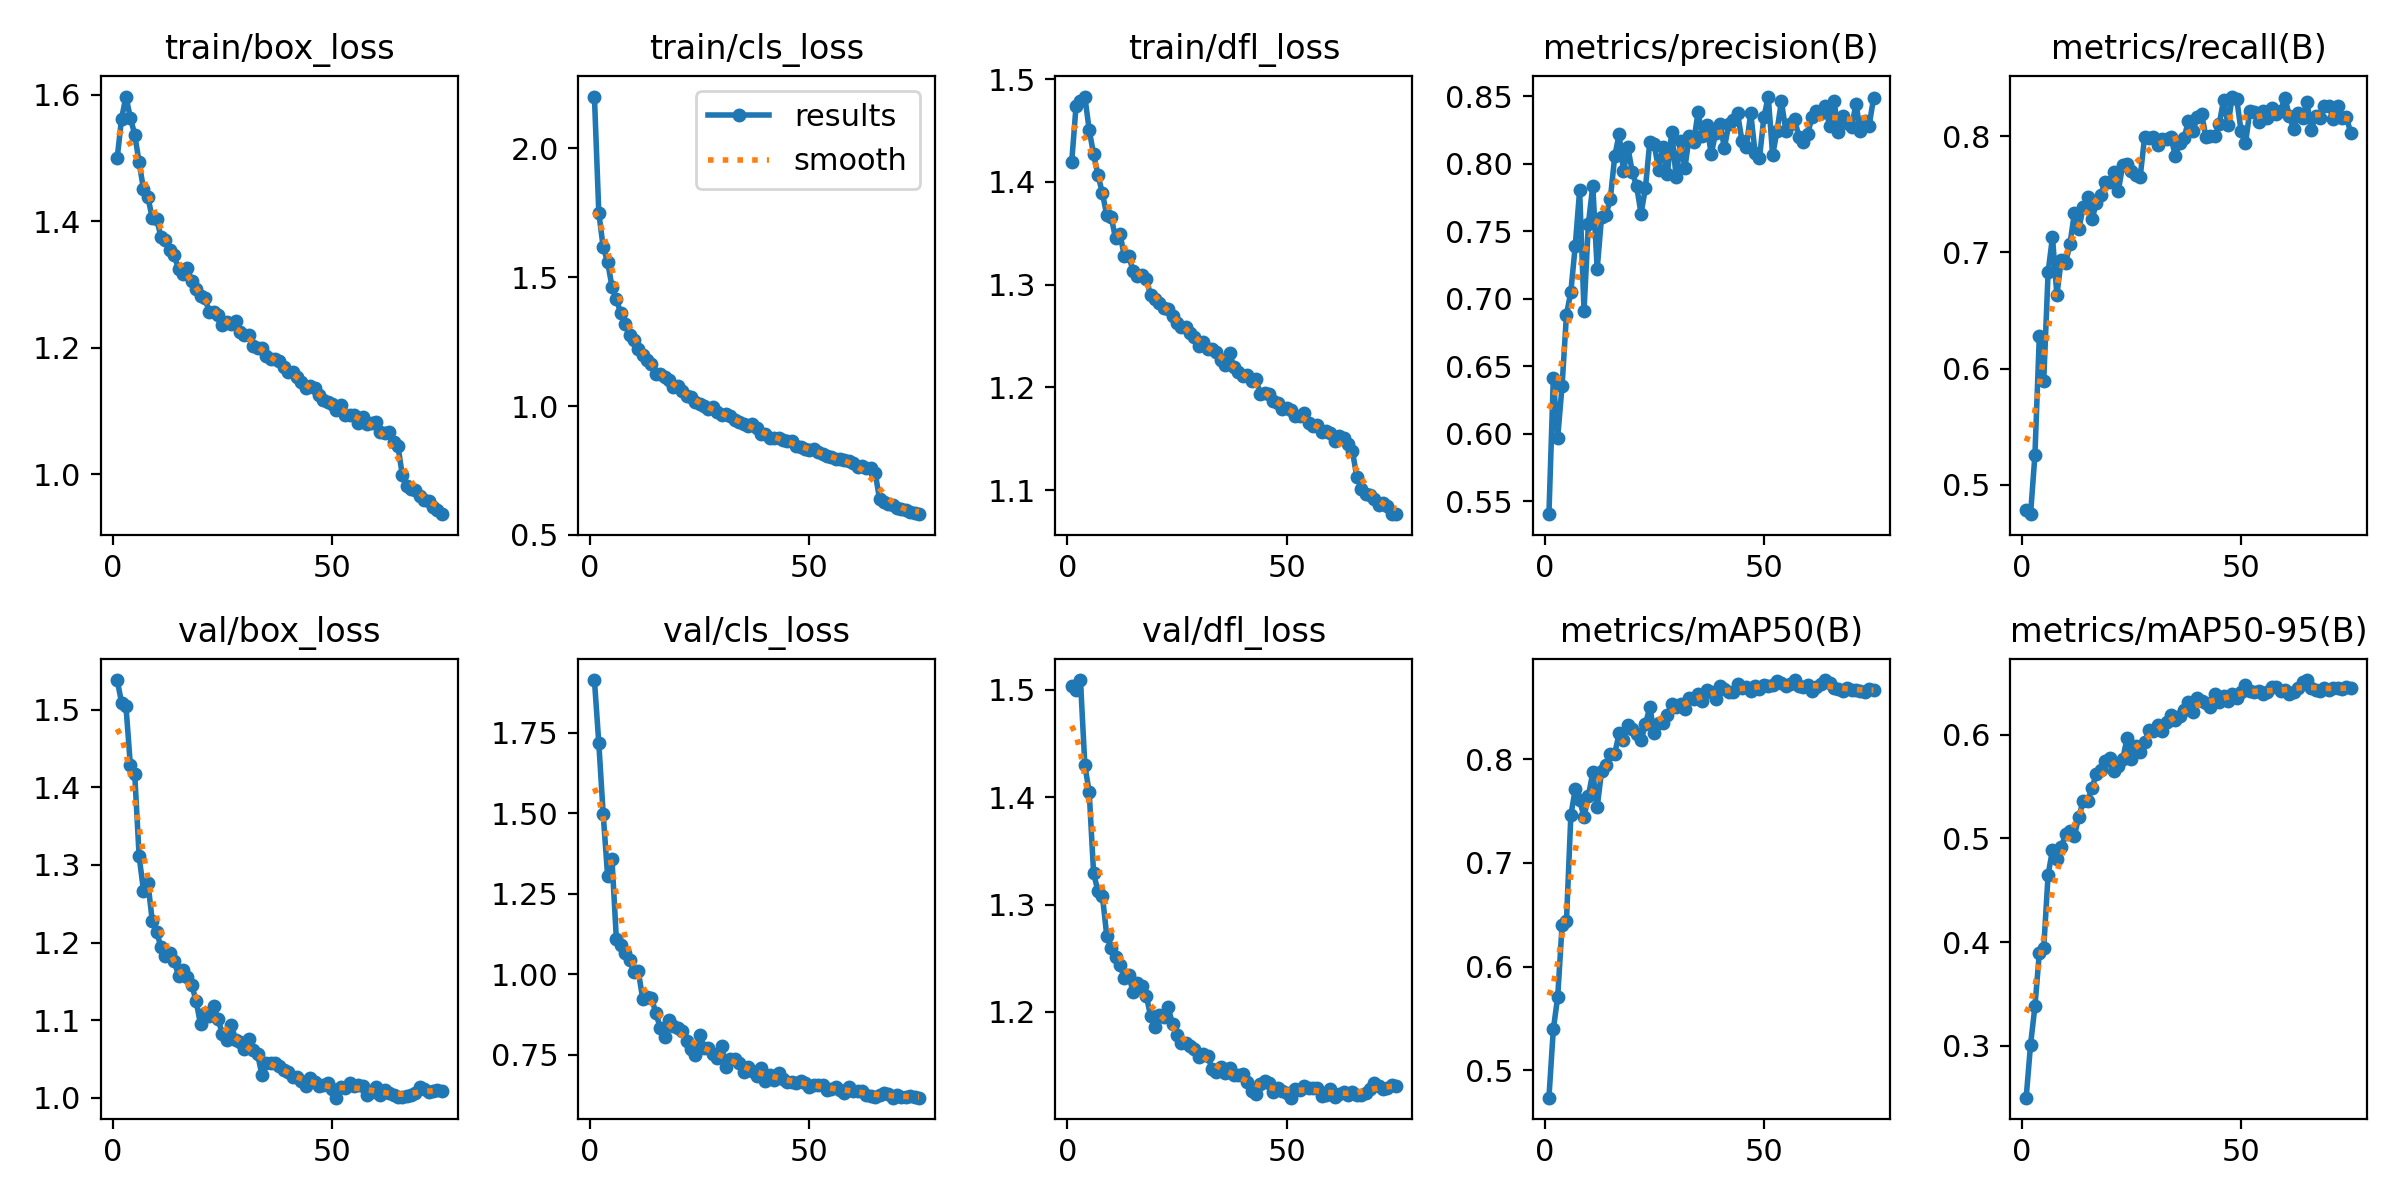

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

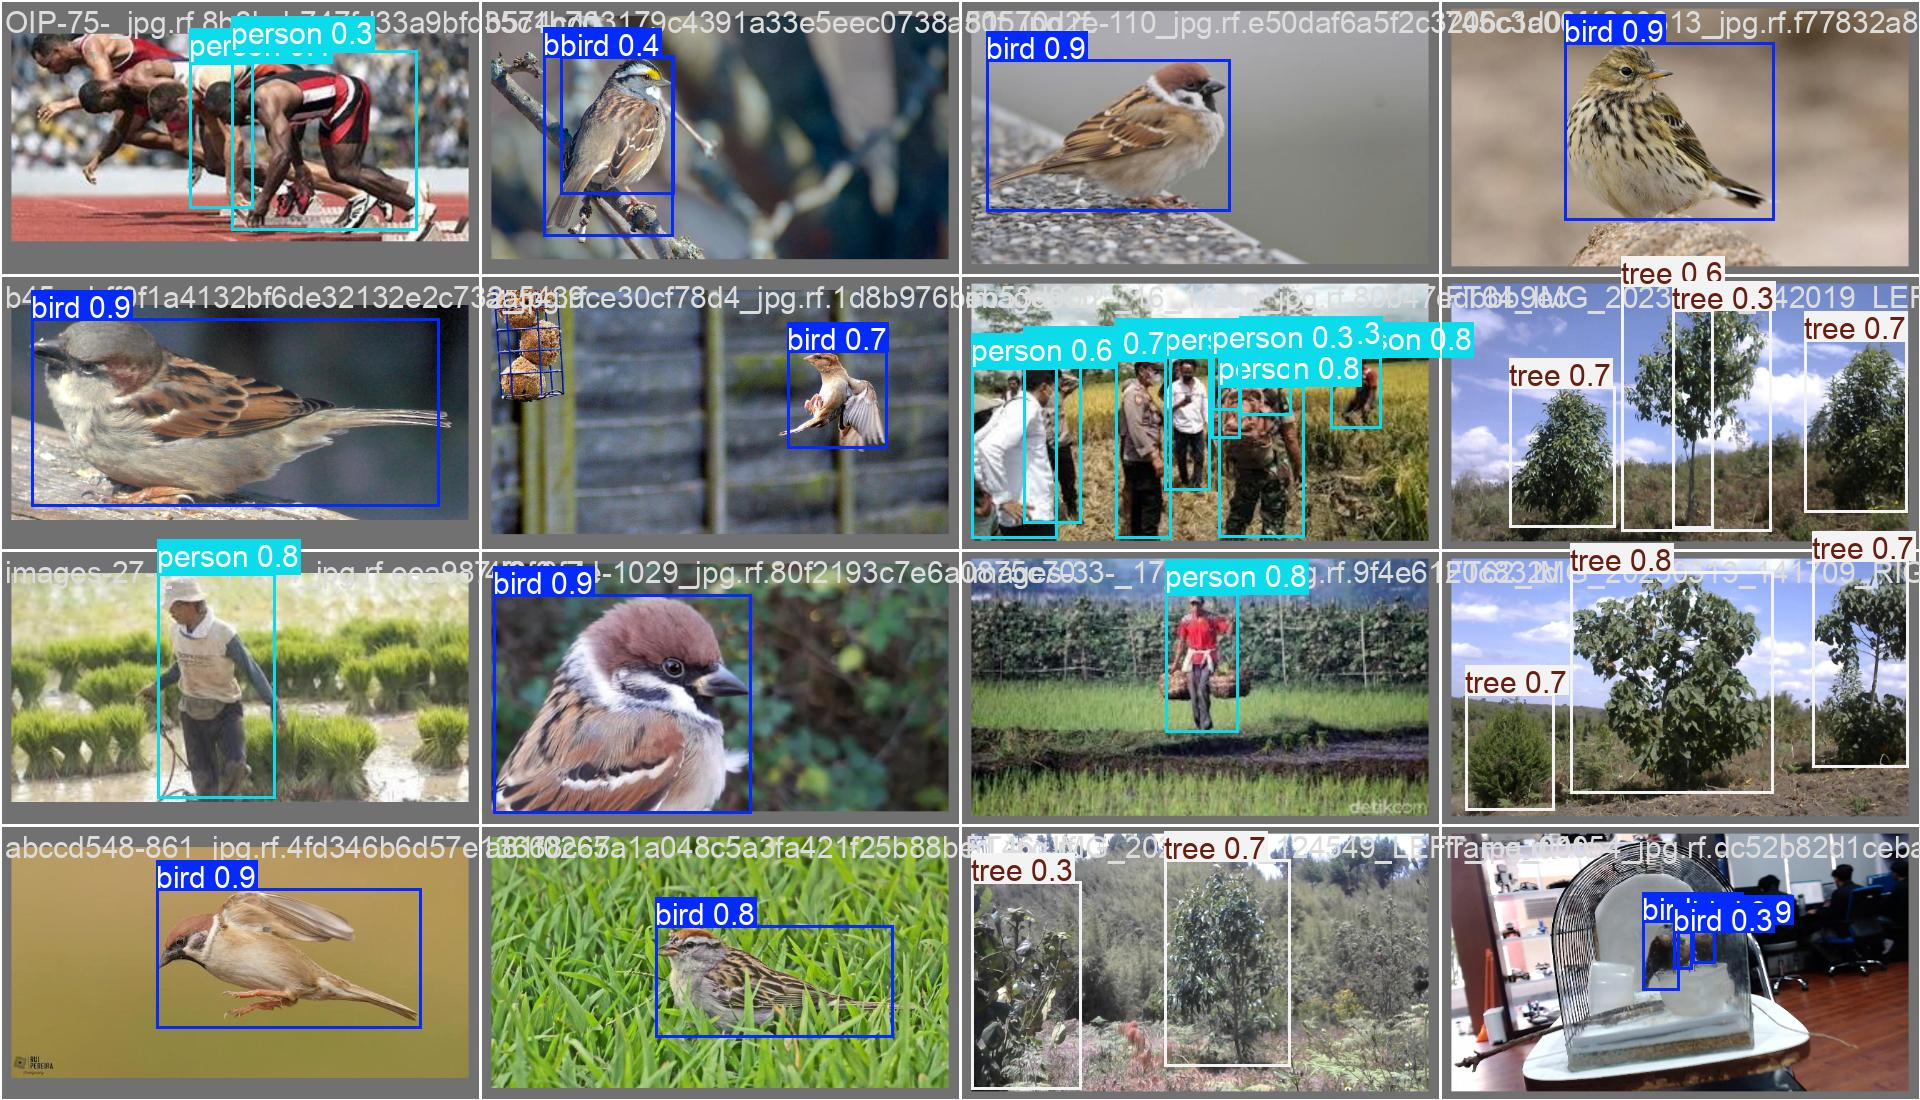

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/datasets/bird-fix-1/valid/labels.cache... 1619 images, 8 backgrounds, 0 corrupt: 100% 1619/1619 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 27, len(boxes) = 3642. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 102/102 [00:18<00:00,  5.42it/s]
                   all       1619       3642      0.829      0.829      0.874      0.652
                  bird       1193       2566      0.843      0.832      0.884      0.549
                person        395        753       0.88      0.923      0.952      0.769
                  tree        13

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 972, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 557, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/predictor.py", line 188, in predict_cli
    for _ in gen:  # sourcery skip: remove-empty-nested-block, noqa
  File "/usr/local/lib/python3.11/dist-packages/tor

**NOTE:** Let's take a look at few results.

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

ValueError: max() arg is an empty sequence

In [ ]:
import os

# Path tujuan
save_path = "/content/drive/MyDrive/bird-fix-v1"

# Buat folder jika belum ada
os.makedirs(save_path, exist_ok=True)

In [ ]:
!cp -r /content/runs /content/drive/MyDrive/bird-fix-v1/

In [ ]:
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 33%)
  adding: content/runs/detect/train/results.png (deflated 8%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 5%)
  adding: content/runs/detect/train/results.csv (deflated 63%)
  adding: content/runs/detect/train/events.out.tfevents.1754633713.3627a454f545.4232.0 (deflated 90%)
  adding: content/runs/detect/train/PR_curve.png (deflated 11%)
  adding: content/runs/detect/train/train_batch26847.jpg (deflated 10%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 4%)
  adding: content/runs/detect/train/labels.jpg (deflated 23%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 7%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 4%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 32%)
  adding: content/runs/

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Salin seluruh folder /content/runs ke folder Skripsi di Google Drive
!cp -r /content/runs /content/drive/MyDrive/runs1